# Loading data

I chose the problem of sentiment classification because this topic is close to me (my diploma was related to verbal aggression detection in social networks).

In [ ]:
%%bash
pip install torch youtokentome transformers catalyst
wget -q https://github.com/strawberrypie/rusentiment/raw/master/Dataset/rusentiment_random_posts.csv
wget -q https://raw.githubusercontent.com/strawberrypie/rusentiment/master/Dataset/rusentiment_test.csv

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import transformers
from catalyst.dl.runner.supervised import SupervisedRunner
from catalyst.utils import set_global_seed

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

In [5]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [6]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
set_global_seed(SEED)

In [7]:
BATCH_SIZE = 64
LR = 1e-5

In [8]:
train = pd.read_csv('rusentiment_random_posts.csv')
test = pd.read_csv('rusentiment_test.csv')
test.head()

,label,text
0,neutral,"Александр, тебе к лицу эта пушка :)\n"
1,positive,"Скоро ты вернешься домой, грязный, не бритый н..."
2,neutral,помниш...))
3,skip,Мы просто с [id12210212|Елисеем] психанули )...
4,speech,"ой, прости забыла поздравить, с праздничьком, ..."


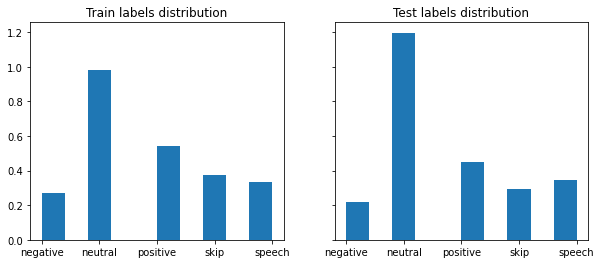

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True)

ax[0].hist(sorted(train.label), density=True);
ax[0].set_title('Train labels distribution');

ax[1].hist(sorted(test.label), density=True);
ax[1].set_title('Test labels distribution');

In [9]:
le = LabelEncoder()
total_labels = pd.concat([train.label, test.label], ignore_index=True).values
le.fit(total_labels)

LabelEncoder()

In [10]:
le.classes_

array(['negative', 'neutral', 'positive', 'skip', 'speech'], dtype=object)

In [11]:
train['label'] = le.transform(train.label)
test['label'] = le.transform(test.label)

In [12]:
def stratified_split(X, y, n_splits: int=1, test_size: float=0.2, 
                     random_state: int=SEED):
    ss = StratifiedShuffleSplit(n_splits=n_splits, 
                                test_size=test_size, 
                                random_state=random_state)
    for train_idx, test_idx in ss.split(X, y):
        yield X[train_idx], y[train_idx], X[test_idx], y[test_idx]

In [13]:
X_train, y_train, X_valid, y_valid = next(iter(stratified_split(train.text.values, 
                                                                train.label.values, 
                                                                test_size=0.1)))
X_test, y_test = test.text, test.label
X_train.shape, X_valid.shape, X_test.shape

((19141,), (2127,), (2967,))

# Teacher

In [ ]:
url = 'http://files.deeppavlov.ai/deeppavlov_data/bert/rubert_cased_L-12_H-768_A-12_pt.tar.gz'

In [ ]:
%%bash -s "$url"
wget -O rubert.tar.gz $1
mkdir -p rubert && tar -C rubert/ -zxvf rubert.tar.gz --strip-components=1
mv rubert/bert_config.json rubert/config.json

## Tokenizer

In [15]:
model_name = 'rubert'
bert_tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

## Dataset and dataloader

In [16]:
import classification_dataset as clf

In [17]:
train_dataset = clf.ClassificationDataset(X_train, y_train, bert_tokenizer)
valid_dataset = clf.ClassificationDataset(X_valid, y_valid, bert_tokenizer)
test_dataset = clf.ClassificationDataset(X_test, y_test, bert_tokenizer)

In [18]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_loaders = {'train': train_loader, 
                 'valid': valid_loader}

## Model

In [19]:
import bert
import losses
from runner import CustomRunner

In [20]:
def init_optim(model: nn.Module, lr: float=1e-4):
    optimizer_grouped_parameters = [
                                    {'params': 
                                     [p for n, p in model.named_parameters()], 
                                     'weight_decay': 0.},]
    optimizer = transformers.AdamW(optimizer_grouped_parameters, lr=lr)
    return optimizer

In [21]:
teacher = bert.BertForSeqClf('rubert', len(le.classes_))
optimizer = init_optim(teacher, LR)
criterion = losses.CELossWithT()

In [23]:
run = CustomRunner(device=DEVICE)

In [24]:
run.train(
    model=teacher,
    optimizer=optimizer,
    criterion=criterion,
    loaders=train_loaders,
    valid_loader='valid',
    logdir='/logs',
    num_epochs=3,
    verbose=True,
    load_best_on_end=True,
    main_metric='f1_score', 
    minimize_metric=False
)

1/3 * Epoch (train): 100% 300/300 [03:21<00:00,  1.49it/s, f1_score=0.389, loss=1.096]
1/3 * Epoch (valid): 100% 34/34 [00:07<00:00,  4.45it/s, f1_score=0.557, loss=0.591]
[2020-09-25 11:05:20,225] 
1/3 * Epoch 1 (train): f1_score=0.5061 | loss=1.0098
1/3 * Epoch 1 (valid): f1_score=0.6331 | loss=0.8335
2/3 * Epoch (train): 100% 300/300 [03:25<00:00,  1.46it/s, f1_score=0.167, loss=1.209]
2/3 * Epoch (valid): 100% 34/34 [00:07<00:00,  4.48it/s, f1_score=0.547, loss=0.655]
[2020-09-25 11:11:59,037] 
2/3 * Epoch 2 (train): f1_score=0.6777 | loss=0.7354
2/3 * Epoch 2 (valid): f1_score=0.6202 | loss=0.8143
3/3 * Epoch (train): 100% 300/300 [03:25<00:00,  1.46it/s, f1_score=0.778, loss=0.495]
3/3 * Epoch (valid): 100% 34/34 [00:07<00:00,  4.47it/s, f1_score=0.557, loss=0.541]
[2020-09-25 11:17:24,632] 
3/3 * Epoch 3 (train): f1_score=0.7417 | loss=0.6050
3/3 * Epoch 3 (valid): f1_score=0.6744 | loss=0.7817
Top best models:
/logs/checkpoints/train.3.pth	0.6744
=> Loading checkpoint /logs/che

In [25]:
logits, loss, score = run.predict_loader(test_loader)

In [26]:
loss, score

(0.7044458370259468, 0.6654759426457386)

# Student

## Tokenizer

In [22]:
from bpe_tokenizer import BPETokenizer

In [23]:
%%time
bpe_tokenizer = BPETokenizer()
bpe_tokenizer.gen_txt(pd.concat([train.text, test.text], ignore_index=True))
bpe_tokenizer.train(vocab_size=10000)

CPU times: user 760 ms, sys: 214 ms, total: 974 ms
Wall time: 684 ms


## Dataset and dataloader

In [24]:
import student_dataset as st

In [25]:
train_dataset_st = st.StudentDataset(X_train, y_train, bpe_tokenizer.bpe_model)
valid_dataset_st = st.StudentDataset(X_valid, y_valid, bpe_tokenizer.bpe_model)
test_dataset_st = st.StudentDataset(X_test, y_test, bpe_tokenizer.bpe_model)

In [26]:
train_loader_st = DataLoader(train_dataset_st, batch_size=BATCH_SIZE, 
                          shuffle=True, collate_fn=train_dataset_st.collate_fn)
valid_loader_st = DataLoader(valid_dataset_st, batch_size=BATCH_SIZE, 
                          shuffle=False, collate_fn=valid_dataset_st.collate_fn)
test_loader_st = DataLoader(test_dataset_st, batch_size=BATCH_SIZE, 
                         shuffle=False, collate_fn=test_dataset_st.collate_fn)

In [27]:
train_loaders_st = {'train': train_loader_st, 
                    'valid': valid_loader_st}

In [28]:
vocab_size = bpe_tokenizer.bpe_model.vocab_size()
padding_idx = bpe_tokenizer.bpe_model.subword_to_id('PAD')

## Model

In [29]:
from student import Student

In [30]:
LR_S = 1e-3

In [31]:
student = Student(input_size=vocab_size, embedding_dim=128, hidden_dim=128, 
                  padding_idx=padding_idx, bidirect=True, 
                  n_layers=2, dropout_p=0.3, n_classes=len(le.classes_))
optimizer = init_optim(student, lr=LR_S)
criterion = losses.CELossWithT()

In [32]:
run1 = CustomRunner(device=DEVICE)

In [33]:
# training baseline model
run1.train(
    model=student,
    optimizer=optimizer,
    criterion=criterion,
    loaders=train_loaders_st,
    valid_loader='valid',
    logdir='/logs',
    num_epochs=5,
    verbose=True,
    load_best_on_end=True,
    main_metric='f1_score', 
    minimize_metric=False
)

1/5 * Epoch (train): 100% 300/300 [00:05<00:00, 51.70it/s, f1_score=0.190, loss=1.222]
1/5 * Epoch (valid): 100% 34/34 [00:00<00:00, 98.12it/s, f1_score=0.316, loss=1.088]
[2020-09-25 11:28:43,311] 
1/5 * Epoch 1 (train): f1_score=0.2894 | loss=1.2971
1/5 * Epoch 1 (valid): f1_score=0.3595 | loss=1.1927
2/5 * Epoch (train): 100% 300/300 [00:05<00:00, 53.49it/s, f1_score=0.000e+00, loss=1.783]
2/5 * Epoch (valid): 100% 34/34 [00:00<00:00, 97.10it/s, f1_score=0.533, loss=0.900]
[2020-09-25 11:28:49,395] 
2/5 * Epoch 2 (train): f1_score=0.4451 | loss=1.0887
2/5 * Epoch 2 (valid): f1_score=0.4629 | loss=1.0970
3/5 * Epoch (train): 100% 300/300 [00:05<00:00, 53.91it/s, f1_score=1.000, loss=0.410]
3/5 * Epoch (valid): 100% 34/34 [00:00<00:00, 98.78it/s, f1_score=0.613, loss=0.967]
[2020-09-25 11:28:55,424] 
3/5 * Epoch 3 (train): f1_score=0.5674 | loss=0.9285
3/5 * Epoch 3 (valid): f1_score=0.5163 | loss=1.0402
4/5 * Epoch (train): 100% 300/300 [00:05<00:00, 53.05it/s, f1_score=0.350, loss=0

In [34]:
logits, loss, score = run1.predict_loader(test_loader_st)
loss, score

(0.9944408891048837, 0.5583305396883095)

We see that student baseline model gives worst $f_1$ than the teacher. Now let's try to improve student's predictions by training it on teacher's logits with different softmax temperatures.

# Distillation

In [35]:
from catalyst import dl

In [36]:
#  softmax temperatures
T = list(range(1, 30, 4))
res = dict.fromkeys(T)

teacher_criterion = losses.CELossWithT()
student_criterion = losses.DistillationLoss(alpha=3)
run2 = CustomRunner(device=DEVICE)

In [37]:
def teacher_predict(run: dl.Runner, dataloaders: dict):
    d = dict.fromkeys(dataloaders.keys())
    test_loss = test_score = 0
    for dl_name, loader in dataloaders.items():
        logit, loss, score = run.predict_loader(loader)
        d[dl_name] = logit.cpu().numpy()
        if dl_name == 'test':
            test_loss = loss; test_score = score
    return d, test_loss, test_score

In [38]:
%%time
for t in T:
    teacher = bert.BertForSeqClf('rubert', len(le.classes_))
    teacher_criterion.set_temp(t)
    optimizer_t = init_optim(teacher, LR)
    run2.train(model=teacher, 
            optimizer=optimizer_t, 
            criterion=teacher_criterion, 
            loaders=train_loaders, 
            valid_loader='valid', 
            num_epochs=3, 
            verbose=True, 
            load_best_on_end=True, 
            logdir='logs/', 
            main_metric='f1_score', 
            minimize_metric=False)

    logits, teacher_loss, teacher_score = teacher_predict(run2, {'train': train_loader, 
                                                                'valid': valid_loader,
                                                                'test': test_loader})

    res[t] = {'teacher_loss': teacher_loss, 'teacher_score': teacher_score}

    train_dataset_st.change_logits(logits['train'])
    valid_dataset_st.change_logits(logits['valid'])
    test_dataset_st.change_logits(logits['test'])

    train_loader_st = DataLoader(train_dataset_st, batch_size=BATCH_SIZE, 
                                shuffle=True, collate_fn=train_dataset_st.collate_fn)
    valid_loader_st = DataLoader(valid_dataset_st, batch_size=BATCH_SIZE, 
                                shuffle=False, collate_fn=valid_dataset_st.collate_fn)
    test_loader_st = DataLoader(test_dataset_st, batch_size=BATCH_SIZE, 
                                shuffle=False, collate_fn=test_dataset_st.collate_fn)

    train_loaders_st['train'] = train_loader_st
    train_loaders_st['valid'] = valid_loader_st
    
    student = Student(input_size=vocab_size, embedding_dim=128, hidden_dim=128, 
                padding_idx=padding_idx, bidirect=True, 
                n_layers=2, dropout_p=0.3, n_classes=len(le.classes_))
    student_criterion.set_temp(t)
    optimizer_st = init_optim(student, LR_S)
    run2.train(model=student, 
            optimizer=optimizer_st, 
            criterion=student_criterion, 
            loaders=train_loaders_st, 
            valid_loader='valid', 
            num_epochs=5, 
            verbose=True, 
            load_best_on_end=True, 
            logdir='/logs', 
            main_metric='f1_score', 
            minimize_metric=False)

    student_logits, student_loss, student_score = run2.predict_loader(test_loader_st)
    res[t].update({'student_loss': student_loss, 'student_score': student_score})

1/3 * Epoch (train): 100% 300/300 [02:59<00:00,  1.67it/s, f1_score=0.292, loss=1.092]
1/3 * Epoch (valid): 100% 34/34 [00:06<00:00,  5.01it/s, f1_score=0.557, loss=0.591]
[2020-09-25 11:32:39,403] 
1/3 * Epoch 1 (train): f1_score=0.4945 | loss=1.0413
1/3 * Epoch 1 (valid): f1_score=0.6298 | loss=0.8463
2/3 * Epoch (train): 100% 300/300 [03:01<00:00,  1.66it/s, f1_score=0.167, loss=1.482]
2/3 * Epoch (valid): 100% 34/34 [00:06<00:00,  4.95it/s, f1_score=0.577, loss=0.663]
[2020-09-25 11:38:52,776] 
2/3 * Epoch 2 (train): f1_score=0.6721 | loss=0.7514
2/3 * Epoch 2 (valid): f1_score=0.6032 | loss=0.8328
3/3 * Epoch (train): 100% 300/300 [03:00<00:00,  1.66it/s, f1_score=1.000, loss=0.374]
3/3 * Epoch (valid): 100% 34/34 [00:06<00:00,  4.95it/s, f1_score=0.747, loss=0.521]
[2020-09-25 11:43:53,652] 
3/3 * Epoch 3 (train): f1_score=0.7330 | loss=0.6249
3/3 * Epoch 3 (valid): f1_score=0.6688 | loss=0.7797
Top best models:
logs/checkpoints/train.3.pth	0.6688
=> Loading checkpoint logs/check

In [39]:
for key, item in res.items():
    print('{k:{c}^{n}}'.format(k=f'T={key}', n=40, c='_'))
    print('Teacher: loss {:.4f}, f1-score {:.4f}'.format(item['teacher_loss'], 
                                                      item['teacher_score']))
    print('Student: loss: {:.4f}, f1-score {:.4f}'.format(item['student_loss'], 
                                                         item['student_score']))

__________________T=1___________________
Teacher: loss 0.7066, f1-score 0.6667
Student: loss: 4.8413, f1-score 0.2029
__________________T=5___________________
Teacher: loss 0.7577, f1-score 0.6711
Student: loss: 4.5571, f1-score 0.4218
__________________T=9___________________
Teacher: loss 0.8830, f1-score 0.6581
Student: loss: 4.8146, f1-score 0.5081
__________________T=13__________________
Teacher: loss 1.0863, f1-score 0.6361
Student: loss: 4.9946, f1-score 0.5497
__________________T=17__________________
Teacher: loss 1.1081, f1-score 0.6500
Student: loss: 5.0349, f1-score 0.5618
__________________T=21__________________
Teacher: loss 1.1430, f1-score 0.6318
Student: loss: 5.0600, f1-score 0.5542
__________________T=25__________________
Teacher: loss 1.2137, f1-score 0.6254
Student: loss: 5.1056, f1-score 0.5282
__________________T=29__________________
Teacher: loss 1.3460, f1-score 0.6398
Student: loss: 5.1272, f1-score 0.5480


Now we can see that training student on teacher's logits could improve student's generalization ability (0.5583 vs 0.5618 $f_1$ score on test data). 

From the results obtained it can be concluded that we should carefully choose softmax temperature: at both too low and too high temperatures, the student's generalization ability is getting worse (the higher the temperature, the higher the entropy).